# **1. Mounting Google Drive**

function ConnectButton(){
  console.log("Connect pushed"); 
  document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **2. Libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import time
import math

import cv2
print(f"OpenCV Version: {cv2.__version__}")

print(f'TensorFlow Version : {tf.__version__}')
import matplotlib.pyplot as plt

OpenCV Version: 4.1.2
TensorFlow Version : 2.7.0


# **3. Data load**

In [ ]:
tfrec_folder = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/data_files/data/"
csv_folder = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/data_files/"

Reading CSV:

In [ ]:
csv_columns = ["path_name","No Finding","Atelectasis","Consolidation","Infiltration","Pneumothorax","Edema","Emphysema","Fibrosis","Effusion","Pneumonia","Pleural_Thickening","Cardiomegaly","Nodule","Mass","Hernia"]
data_csv = pd.read_csv(csv_folder+"preprocessed_data.csv",skiprows=[0], header = None, names = csv_columns)
data_csv.head()

,path_name,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,../input/data/images_001/images/00000001_000.png,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,../input/data/images_001/images/00000001_001.png,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,../input/data/images_001/images/00000001_002.png,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
3,../input/data/images_001/images/00000002_000.png,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,../input/data/images_001/images/00000003_000.png,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [ ]:
len(data_csv)

112120

El siguiente feature_map ayuda a descomponer cada una de los samples del TREC (imagenes) en informacion importante de cada uno de ellos:

In [ ]:
feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_id': tf.io.FixedLenFeature([], tf.string),
    'No Finding': tf.io.FixedLenFeature([], tf.int64),
    'Atelectasis': tf.io.FixedLenFeature([], tf.int64),
    'Consolidation': tf.io.FixedLenFeature([], tf.int64),
    'Infiltration': tf.io.FixedLenFeature([], tf.int64),
    'Pneumothorax': tf.io.FixedLenFeature([], tf.int64),
    'Edema': tf.io.FixedLenFeature([], tf.int64),
    'Emphysema': tf.io.FixedLenFeature([], tf.int64),
    'Fibrosis': tf.io.FixedLenFeature([], tf.int64),
    'Effusion': tf.io.FixedLenFeature([], tf.int64),
    'Pneumonia': tf.io.FixedLenFeature([], tf.int64),
    'Pleural_Thickening': tf.io.FixedLenFeature([], tf.int64),
    'Cardiomegaly': tf.io.FixedLenFeature([], tf.int64),
    'Nodule': tf.io.FixedLenFeature([], tf.int64),
    'Mass': tf.io.FixedLenFeature([], tf.int64),
    'Hernia': tf.io.FixedLenFeature([], tf.int64)
}

# **4. TF Datasets' creation**

La siguiente función permite preprocesar una determinada imagen y devolverla junto con su label (enfermedad toracica).

In [ ]:
def image_decoder(data, resize_shape = (300,300)):
    example = tf.io.parse_single_example(data, feature_map)
    image = example['image']
    image = tf.io.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, resize_shape[0], resize_shape[1])
    image.set_shape(resize_shape+(3,))
    image = tf.cast(image, tf.float32) / 255.0
    
    print([label for label in sorted(list(example.keys())) if label!='image' and label!='image_id' and label != "No Finding"])
    labels = [tf.cast(example[x], tf.float32) for x in sorted(list(example.keys())) if x!='image_id' and x != "No Finding" and x!="" and x!='image']
    
    #id = tf.cast(example['image_id'], tf.string)
    #return image, labels, id

    return image, labels

La siguiente funcion es capaz de crear un `TensorFlow Dataset` desde un archivo TF Record.
La salida va a ser un ``prefetchDataset`` lo cual permite realizar el preprocesamiento de los datos a la vez que entrenamiento de TF para no bloquear el disco disponible con demasiado I/O.
Vemos como el numero de datos spobre los que se realiza el preset esta puesto como AUTOTUNE. Esto lo que hará es cambiar el numero de datos que se sacan del buffer dinamicamente en base al entrenamiento dependiendo de cuantos datos por batch necesite este.
Info importante sobre esto: https://www.tensorflow.org/guide/data_performance#prefetching

In [ ]:
def tfr_decoder(path, shuffle=True, train_percent=0.8, val_percent=0.1, batch_size = 128, prefetch = True):

    data_list = [os.path.join(path,x) for x in os.listdir(path)]
    data_list.sort()
    #data_list = data_list[:30]
    train_end = int(len(data_list)*train_percent) 
    val_end = train_end + int(len(data_list)*val_percent)
    train_data, val_data, test_data = data_list[:train_end], data_list[train_end:val_end], data_list[val_end:]
    
    trainds = tf.data.TFRecordDataset(train_data)
    trainds = trainds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    trainds = trainds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
    #print("Lenght of train dataset: " + str(sum(1 for _ in trainds)))
    
    valds = tf.data.TFRecordDataset(val_data)
    valds = valds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valds = valds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
    #print("Lenght of val dataset: " + str(sum(1 for _ in valds)))

    testds = tf.data.TFRecordDataset(test_data)
    testds = testds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    testds = testds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
    #print("Lenght of val dataset: " + str(sum(1 for _ in testds)))

    if shuffle:
        trainds = trainds.shuffle(1024)

    if batch_size != None:
      trainds = trainds.batch(batch_size)
      valds = valds.batch(batch_size)
      testds = testds.batch(batch_size)

    if prefetch:
      trainds = trainds.prefetch(tf.data.experimental.AUTOTUNE)
      valds = valds.prefetch(tf.data.experimental.AUTOTUNE)
      testds = testds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return trainds, valds, testds
      

Creamos los datasets de **Train y Validation**


In [ ]:
train_ds, val_ds, test_ds = tfr_decoder(tfrec_folder)
print(type(train_ds))
print(train_ds)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<PrefetchDataset shapes: ((None, 300, 300, 3), (None, 14)), types: (tf.float32, tf.float32)>


# **5. Showing datasets images**

In [ ]:
class_names_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

### With next(iter(df))

In [ ]:
def show_batch(X, Y):
    plt.figure(figsize=(15, 15))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(X[n])
        
        result = [x for i, x in enumerate(class_names_list) if Y[n][i]]
        title = "+".join(result)

        plt.title(title)
        plt.axis("off")

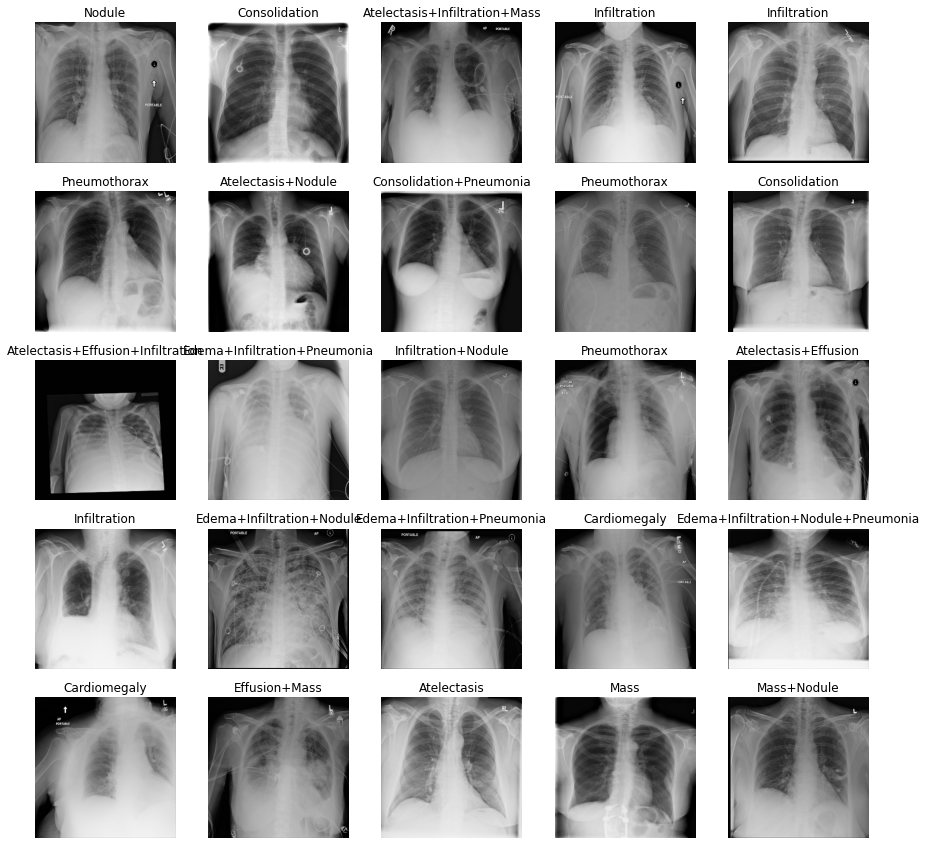

In [ ]:
image_viz, label_viz = next(iter(train_ds))

show_batch(image_viz.numpy(), label_viz.numpy())

# **6. Modeling**

### 6.1 Efficient Net 

Vamos a iutilizar la red de google efficientNet ya pre-entrenada para vectorizar las imagenes
https://keras.io/api/applications/

#### 6.1.1 Model construction
La ultima capa queremos que tenga 15 neuronas ( `out_shape = len(class_names_list)` ) y una activacion activacion `sigmoid` para que la salida de la red sean probabilidades para cada una de las patologías.

In [ ]:
image_size = (	300,	300)
out_shape = len(class_names_list)

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3

In [ ]:
effNet = EfficientNetB3(input_shape = image_size +(3,), include_top = False, weights = 'imagenet', drop_connect_rate=0.4)
#Freeze trainable parameters:
for layer in effNet.layers:
  layer.trainable = False
#Unfreezee some layers for fine tunning
for layer in effNet.layers[-20:]:
      if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')

x = effNet(inputs)
x = layers.Flatten() (x)
x = layers.BatchNormalization() (x)
x = layers.Dense(256, "relu") (x)
x = layers.Dropout(0.5) (x)
x = layers.BatchNormalization() (x)
x = layers.Dense(128, "relu") (x)
x = layers.Dropout(0.5) (x)
x = layers.BatchNormalization() (x)
x = layers.Dense(64, "relu") (x)
x = layers.Dropout(0.5) (x)
x = layers.BatchNormalization() (x)
outputs = layers.Dense(out_shape, 'sigmoid')(x)

In [ ]:
effNet_model = keras.Model(inputs = inputs, outputs = outputs, name = "effNet_model")
effNet_model.summary()


Model: "effNet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 batch_normalization (BatchN  (None, 153600)           614400    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               39321856  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

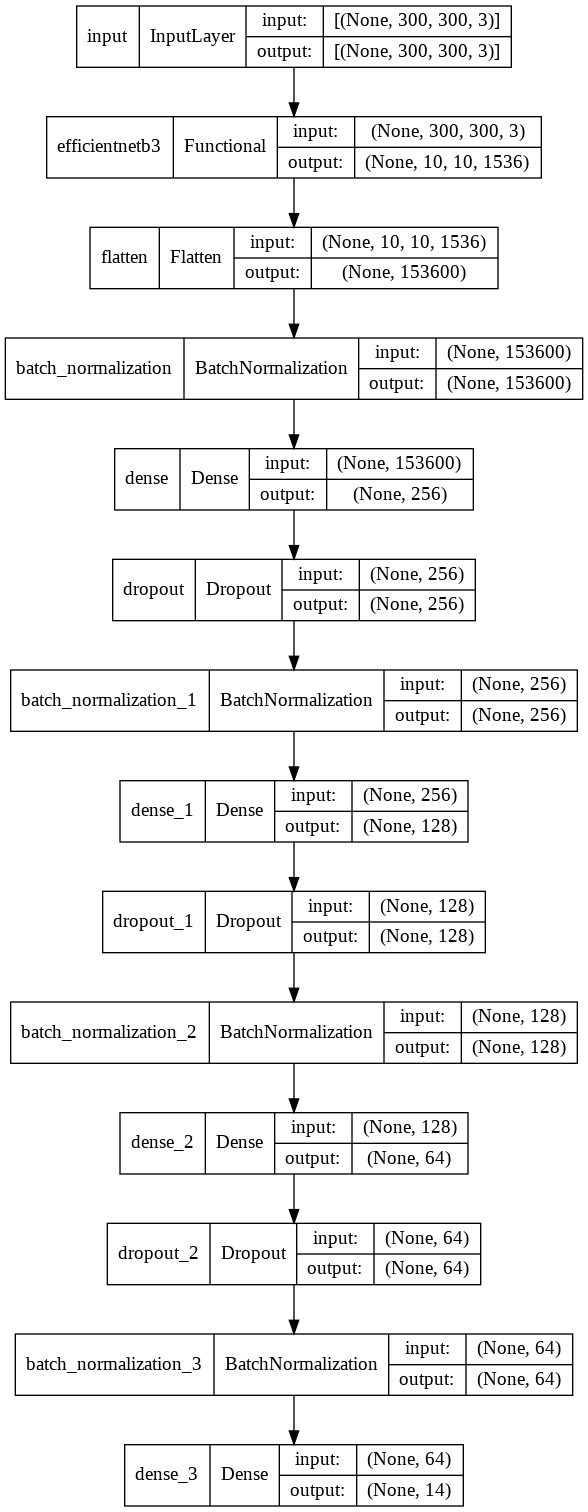

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(effNet_model, show_shapes=True)

#### 6.1.2 Fitting

In [ ]:
n_epochs = 35
lr= 0.0001
bath_size = 128

data_list = [os.path.join(tfrec_folder,x) for x in os.listdir(tfrec_folder)]
data_list.sort()
#data_list = data_list[:30]
train_end = int(len(data_list)*0.8) 
val_end = train_end + int(len(data_list)*0.1)
train_data, val_data, test_data = data_list[:train_end], data_list[train_end:val_end], data_list[val_end:]

train_size = sum(1 for _ in tf.data.TFRecordDataset(train_data))
validation_size = sum(1 for _ in tf.data.TFRecordDataset(val_data))

epoch_steps = int(np.ceil(train_size/bath_size))
validation_steps = int(np.ceil(validation_size/bath_size))

print("steps_per_epoch: " + str(epoch_steps))
print("validation_steps: " + str(validation_steps))

steps_per_epoch: 699
validation_steps: 86


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [ ]:
path_to_models = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/modelos/"
model_name = "effNet_20ep_lr0p001.h5"

path_to_history = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/historiales/"
history_name = "history_effNet_20ep_lr0p001.pickle"

ckp = ModelCheckpoint(path_to_models+model_name,monitor = 'val_loss',
                      verbose = 1, save_best_only = True, mode = 'min')
        
es = EarlyStopping(monitor = 'val_loss', patience = 4, mode = 'min', 
                    restore_best_weights = True, verbose = 1)

In [ ]:
effNet_model.compile(
              loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
              optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001),
              metrics= [ tf.keras.metrics.AUC(multi_label=True) ]
             )

In [ ]:
start = time.time()
history = effNet_model.fit(
                      train_ds, 
                      epochs=20,
                      callbacks=[es,ckp],
                      validation_data=val_ds
)
effNet_model.save(path_to_models+model_name)
import pickle
with open(path_to_history+history_name, 'wb') as f:
    pickle.dump(history, f)
end = time.time()
train_time = (end-start)/60
print(str(train_time) + " minutos tardó en entrenar")

Epoch 1/20
    323/Unknown - 195s 537ms/step - loss: 0.8563 - auc_1: 0.5001
Epoch 00001: val_loss improved from inf to 0.67447, saving model to /content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/modelos/effNet_20ep_lr0p001.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


323/323 [==============================] - 219s 614ms/step - loss: 0.8563 - auc_1: 0.5001 - val_loss: 0.6745 - val_auc_1: 0.4984
Epoch 2/20
323/323 [==============================] - ETA: 0s - loss: 0.8381 - auc_1: 0.5039
Epoch 00002: val_loss improved from 0.67447 to 0.65659, saving model to /content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/modelos/effNet_20ep_lr0p001.h5
323/323 [==============================] - 194s 590ms/step - loss: 0.8381 - auc_1: 0.5039 - val_loss: 0.6566 - val_auc_1: 0.5046
Epoch 3/20
323/323 [==============================] - ETA: 0s - loss: 0.8249 - auc_1: 0.4991
Epoch 00003: val_loss improved from 0.65659 to 0.65000, saving model to /content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/modelos/effNet_20ep_lr0p001.h5
323/323 [==============================] - 194s 589ms/step - loss: 0.8249 - auc_1: 0.4991 - val_loss: 0.6500 - val_auc_1: 0.5003
Epoch 4/20
323/323 [==============================] - ETA: 0s - loss: 0.8108 - 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


67.44282195568084 minutos tardó en entrenar


Guardamos el modelo e historial:

In [ ]:
path_to_models+model_name[:-3]+"_SGD_FINISIH.h5"

'/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/modelos/effNet_20ep_lr0p001_SGD_FINISIH.h5'

In [ ]:
effNet_model.save(path_to_models+model_name[:-3]+"_SGD_FINISIH.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
import pickle
with open(path_to_history+model_name[:-3]+".pickle" ,'wb') as f:
    pickle.dump(history, f)

INFO:tensorflow:Assets written to: ram://33a59e27-b394-4e42-9c2d-063011a221ea/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Una vez entrenado podemos evaluar como se comporta con datos del dataset de validación:

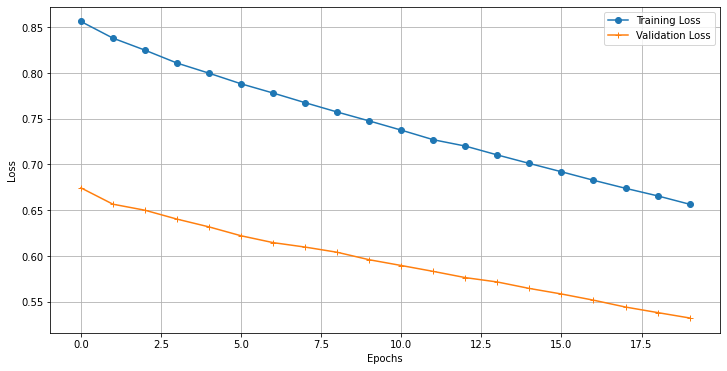

In [ ]:
plt.figure(figsize = (12, 6))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss", marker='o')
plt.plot( history.history["val_loss"], label = "Validation Loss", marker='+')
plt.grid(True)
plt.legend()
plt.show()

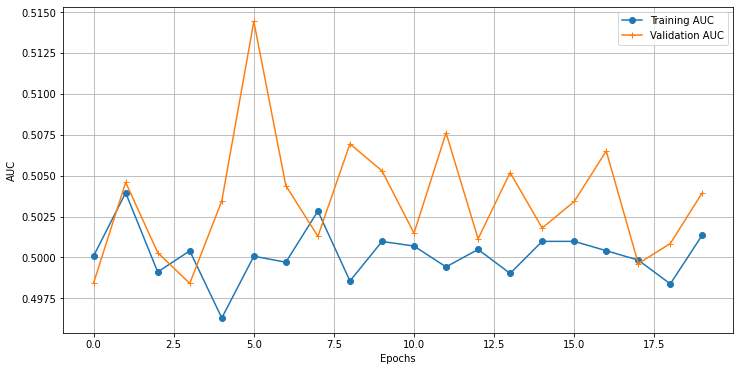

In [ ]:
plt.figure(figsize = (12, 6))
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.plot( history.history["auc_1"], label = "Training AUC" , marker='o')
plt.plot( history.history["val_auc_1"], label = "Validation AUC", marker='+')
plt.grid(True)
plt.legend()
plt.show()

#### 6.1.2 Evaluation

In [ ]:
test_results= effNet_model.evaluate(test_ds, return_dict = True)

test_results

43/43 [==============================] - 23s 515ms/step - loss: 0.5316 - auc_1: 0.5013


{'auc_1': 0.5013452768325806, 'loss': 0.5316359400749207}

In [ ]:
predictions = effNet_model.predict(test_ds)

In [ ]:
len(predictions)

5429

In [ ]:
 y_pred_df = pd.DataFrame(predictions, columns = class_names_list)
 y_pred_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.419355,0.384302,0.240374,0.561676,0.453737,0.418794,0.398009,0.248231,0.336836,0.237073,0.424570,0.364360,0.279372,0.431549
1,0.417939,0.383896,0.241802,0.565282,0.453288,0.419247,0.398823,0.247370,0.339794,0.238117,0.424831,0.365255,0.281115,0.433202
2,0.417572,0.384021,0.241266,0.563098,0.455112,0.418319,0.398885,0.247257,0.336958,0.237491,0.426068,0.363132,0.279939,0.433357
3,0.417555,0.381284,0.242008,0.564751,0.454712,0.418289,0.399341,0.246856,0.337649,0.236771,0.425785,0.362627,0.281375,0.433543
4,0.420553,0.389314,0.239670,0.559903,0.451408,0.419862,0.397894,0.248878,0.338426,0.239248,0.422819,0.367142,0.277736,0.430094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5424,0.419646,0.384571,0.240588,0.560616,0.452594,0.419589,0.397609,0.248823,0.338390,0.237668,0.423645,0.365918,0.279029,0.430555
5425,0.418603,0.384253,0.241284,0.561904,0.453938,0.419578,0.398431,0.248066,0.338224,0.237610,0.425685,0.364327,0.279457,0.431688
5426,0.418085,0.383174,0.241130,0.563833,0.454785,0.418751,0.398925,0.247205,0.337271,0.237269,0.425924,0.362813,0.280426,0.433142
5427,0.417884,0.382182,0.241329,0.564022,0.453964,0.417880,0.398369,0.247227,0.337213,0.237304,0.425431,0.363250,0.280868,0.432167


In [ ]:
def generate_df_from_prefetch_ds(tf_dataset, len_dataset):
  batch_size = tf_dataset._input_dataset._batch_size.numpy()
  batch_numbers = math.ceil(len_dataset/batch_size)
  matrix = []
  for iteration, sample in enumerate(tf_dataset.take(batch_numbers)):
    if iteration==(int(len_dataset/batch_size)):
      batch_size = len_dataset%batch_size
    for i in range(batch_size):
      matrix.append(list(sample[1][i].numpy()))
  df_test_real = pd.DataFrame(matrix, columns = class_names_list)#.apply(lambda x : x.astype("int32"))
  return df_test_real

In [ ]:
y_real_df = generate_df_from_prefetch_ds(test_ds, len(predictions))

In [ ]:
y_real_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5424,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


We are now going to define two metrics on the test dataset
- **MAP@5** (Mean Average Precision at 5): Esto simboliza que de las primeras 5 probabilidades mas altas cdevueltas por nuestro dataframe (o numero de labels target 1 si es menor), cuantas son las targets deseadas.
![MAP](https://drive.google.com/uc?id=1f36UqUgoEQso6a4GZ2ooMse4A7Hs5gnq)
- **LRAP** (Label Ranking average precision) measures the average precision of the predictive model but instead using precision-recall. It measures the label rankings of each sample. Its value is always greater than 0. The best value of this metric is 1. This metric is related to average precision but used label ranking instead of precision and recall
LRAP basically asks the question that for each of the given samples what percents of the higher-ranked labels were true labels.
Given a binary indicator matrix of ground-truth labels.
EXPLICACION:
https://stackoverflow.com/questions/55881642/how-to-interpret-label-ranking-average-precision-score/56857102
https://www.geeksforgeeks.org/multilabel-ranking-metrics-label-ranking-average-precision-ml/
![MAP](https://drive.google.com/uc?id=1SewLi0d_EupTF_awijPjtZE1Kk2f91qf)

In [ ]:
from sklearn.metrics import label_ranking_average_precision_score

In [ ]:
def get_LRAP(y_pred_df, y_df):
  return label_ranking_average_precision_score(y_true = y_df.values.tolist(), y_score = y_pred_df.values.tolist())

In [ ]:
get_LRAP(y_pred_df, y_real_df)

0.2602428099286776

In [ ]:
def get_MAP_at_k(y_pred_df, y_df, k=3, mean_over_samples = True):
  #Sort vectors based on probabilities of the prediction.
  y_p = []
  y_r = []
  for i in range(len(y_pred_df)):
    y_pred = y_pred_df.iloc[i].values.tolist()
    y_real = y_df.iloc[i].values.tolist()
    indexes_order = np.argsort(y_pred)[::-1]
    y_pred_sorted = [y_pred[k] for k in indexes_order]
    y_real_sorted = [y_real[k] for k in indexes_order]
    y_p.append(y_pred_sorted)
    y_r.append(y_real_sorted)
  #Slice vector to top_k probabilities.
  y_p_k = np.array(y_p)[:,:k]
  y_r_k = np.array(y_r)[:,:k]
  denominator = np.array(list(map(lambda x: min (x,k), np.sum(y_r,axis=1))))
  result = np.sum(y_r_k,axis=1) / denominator
  if mean_over_samples:
    result = np.mean(result)
  return result


In [ ]:
get_MAP_at_k(y_pred_df, y_real_df, k = 3)

0.24970835635783137

## 7. Simulating product output


Vamos a redefinir la funcion de creacion de datasets pero mas parametrizada que nos ayudara a tomar samples aleatorias del dataset

In [ ]:
def tfr_decoder(path, shuffle=True, train_percent=0.8, val_percent=0.1, batch_size = None, prefetch = True):

    data_list = [os.path.join(tfrec_folder,x) for x in os.listdir(path)]
    data_list.sort()
    #data_list = data_list[:30]
    train_end = int(len(data_list)*train_percent) 
    val_end = train_end + int(len(data_list)*val_percent)
    train_data, val_data, test_data = data_list[:train_end], data_list[train_end:val_end], data_list[val_end:]
    
    trainds = tf.data.TFRecordDataset(train_data)
    trainds = trainds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    valds = tf.data.TFRecordDataset(val_data)
    valds = valds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    testds = tf.data.TFRecordDataset(test_data)
    testds = testds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if shuffle:
        trainds = trainds.shuffle(1024)

    if batch_size != None:
      trainds = trainds.batch(batch_size)
      valds = valds.batch(batch_size)
      testds = testds.batch(batch_size)

    if prefetch:
      trainds = trainds.prefetch(tf.data.experimental.AUTOTUNE)
      valds = valds.prefetch(tf.data.experimental.AUTOTUNE)
      testds = testds.prefetch(tf.data.experimental.AUTOTUNE)
      
    return trainds, valds, testds

In [ ]:
def get_images_from_tfr(path,length_dataset, seed=1234, n_of_samples=9):
  _,_,test_ds = tfr_decoder(path, shuffle=True, train_percent=0.8, val_percent=0.1, batch_size = None, prefetch = False)
  #Shuffle the dataset
  images = []
  y_true = []
  test_ds = test_ds.shuffle(length_dataset+1, seed = seed)
  for sample in test_ds.take(n_of_samples):
    images.append(sample[0])
    y_true.append(sample[1])
  images_arr = np.array(images)
  y_true_arr = np.array(y_true)
  print(images_arr.shape, y_true_arr.shape)
  return images_arr, y_true_arr

In [ ]:
def simulate_project_output(model, images, class_names, k_prob = 3 , y_real = None, figure_size = (25,30)):

  y_pred = model.predict(images)
  n_samples = images.shape[0]

  #Getting metrics
  y_pred_df = pd.DataFrame(y_pred, columns = class_names)
  y_real_df = pd.DataFrame(y_real, columns = class_names)
  lrap = get_LRAP(y_pred_df, y_real_df)
  ap_k = get_MAP_at_k(y_pred_df, y_real_df, k=k_prob, mean_over_samples = False)
  mean_ap_k = np.mean(ap_k)

  plt.figure(figsize = figure_size)

  for n in range(n_samples):
    ax = plt.subplot(3, 3, n + 1)
    ax = plt.imshow(images[n])

    y_ref_string = [x for i, x in enumerate(class_names) if y_real[n][i]]
    title = " + ".join(y_ref_string)
    title = "ACTUAL PATOLOGY(S):  " + title + "\n"
    title = title + "PREDICTIONS:\n"

    indexes_order = np.argsort(y_pred[n])[::-1]

    predictions_string = [str(ix) + ". " + class_names[index] + ":  " + str(y_pred[n][index]) for ix, index in enumerate(indexes_order) if ix < k_prob]
    title = title + "\n".join(predictions_string)
    plt.title(title)
    plt.axis("off")


In [ ]:
images_sample, y_sample = get_images_from_tfr(tfrec_folder, len(predictions), seed = 123)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
(9, 300, 300, 3) (9, 14)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


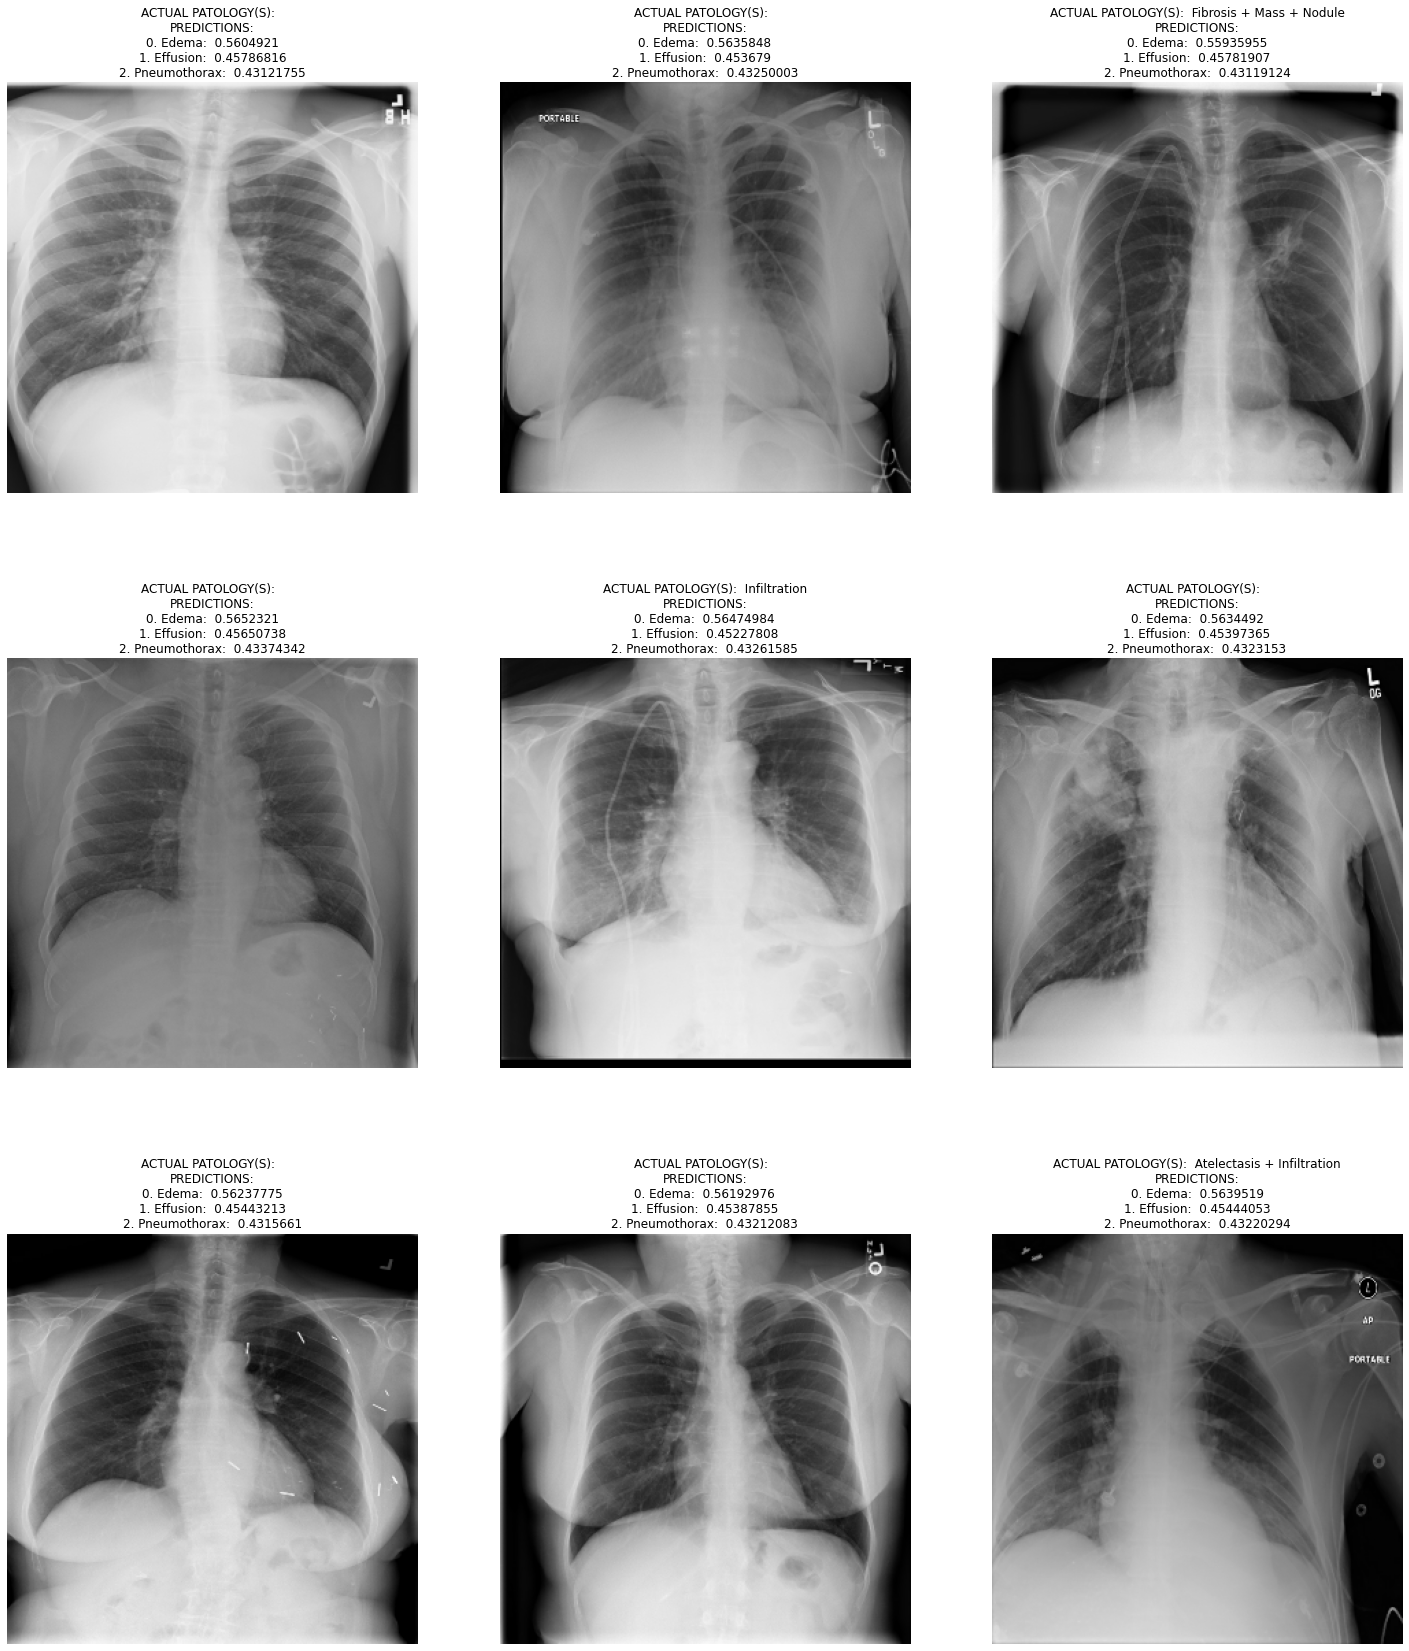

In [ ]:
simulate_project_output(effNet_model, images_sample, class_names_list, k_prob = 3 , y_real = y_sample, figure_size = (25,30))